## Great, now that we discussed a little let's continue

Given that the current approach utilized by the authors lacks reproducibility, we will explore an alternative method by leveraging nf-core pipelines for data analysis.

Please explain, how we will achieve reproducibility for the course  with this approach.


Using nf-core pipelines ensures reproducibility mainly because the workflow is standardized by container, tool and library versions.

You have successfully downloaded 2 of the fastq files we will use in our study.

What is the next step if we want to first have a count table and check the quality of our fastq files? What is the pipeline called to do so?

I would run the pipeline nf-core/rnaseq on the downloaded files, which gives a count table that is ready for DE analysis and a QC report for each file.

Analyze the 2 files using an nf-core pipeline.

What does this pipeline do?

Which are the main tools that will be used in the pipeline?

The pipeline does Merging of the files (Preprocessing with QC), Alignment with Quantification (Genome: STAR/HISAT, Pseudo: Salmon/Kalisco), Post Processing and final QC with an overall report. In detail as described in the intro of the pipeline:

1. Merge re-sequenced FastQ files (cat)
2. Auto-infer strandedness by subsampling and pseudoalignment (fq, Salmon)
3. Read QC (FastQC)
4. UMI extraction (UMI-tools)
5. Adapter and quality trimming (Trim Galore!)
6. Removal of genome contaminants (BBSplit)
7. Removal of ribosomal RNA (SortMeRNA)
8. Choice of multiple alignment and quantification routes (For STAR the sentieon implementation can be chosen):
  - STAR -> Salmon
  - STAR -> RSEM
  - HiSAT2 -> NO QUANTIFICATION
9. Sort and index alignments (SAMtools)
10. UMI-based deduplication (UMI-tools)
11. Duplicate read marking (picard MarkDuplicates)
12. Transcript assembly and quantification (StringTie)
13. Create bigWig coverage files (BEDTools, bedGraphToBigWig)
14. Extensive quality control:
  - RSeQC
  - Qualimap
  - dupRadar
  - Preseq
  - DESeq2
  - Kraken2 -> Bracken on unaligned sequences; optional
15. Pseudoalignment and quantification (Salmon or ‘Kallisto’; optional)
16. Present QC for raw read, alignment, gene biotype, sample similarity, and strand-specificity checks (MultiQC, R)

As all other nf-core pipelines, the chosen pipeline takes in a samplesheet as input.

Use Python and pandas to create the samplesheet for your 2 samples. Feel free to make use of the table you created earlier today.

Choose your sample names wisely, they must be the connection of the results to the metadata. If you can't find the sample in the metadata later, the analysis was useless.

In [1]:
import pandas as pd

samples_info = {
    "Run": ["SRR23195516", "SRR23195511"],
    "SNI": [True, False],
    "Oxy": [True, True],
    "strandedness": 'auto',
    "Bases": [6922564500, 6456390900],

    "fastq_1": [
        "./expression_data/fastq/SRX19144486_SRR23195516_1.fastq.gz",
        "./expression_data/fastq/SRX19144488_SRR23195511_1.fastq.gz"
    ],
    "fastq_2": [
        "./expression_data/fastq/SRX19144486_SRR23195516_2.fastq.gz",
        "./expression_data/fastq/SRX19144488_SRR23195511_2.fastq.gz"
    ]
}

samplesheet = pd.DataFrame(samples_info)
samplesheet["sample"] = samplesheet.apply(lambda x: f"{x['Run']}_SNI{x['SNI']}_Oxy{x['Oxy']}", axis=1)
samplesheet = samplesheet[["sample", "fastq_1", "fastq_2", "strandedness", "SNI", "Oxy", "Bases"]]
samplesheet.to_csv("samplesheet_2_samples.csv", index=False)
samplesheet


,sample,fastq_1,fastq_2,strandedness,SNI,Oxy,Bases
0,SRR23195516_SNITrue_OxyTrue,./expression_data/fastq/SRX19144486_SRR2319551...,./expression_data/fastq/SRX19144486_SRR2319551...,auto,True,True,6922564500
1,SRR23195511_SNIFalse_OxyTrue,./expression_data/fastq/SRX19144488_SRR2319551...,./expression_data/fastq/SRX19144488_SRR2319551...,auto,False,True,6456390900


In [ ]:
!nextflow run nf-core/rnaseq \
  -profile docker \
  --input samplesheet_2_samples.csv \
  --outdir rnaseq-out \
  --genome GRCm38 \
  --paired_end \
  -c nextflow.config \
  -resume



 N E X T F L O W   ~  version 25.04.7

Launching `https://github.com/nf-core/rnaseq` [exotic_heyrovsky] DSL2 - revision: 9738a2df42 [master]


------------------------------------------------------
                                        ,--./,-.
        ___     __   __   __   ___     /,-._.--~'
  |\ | |__  __ /  ` /  \ |__) |__         }  {
  | \| |       \__, \__/ |  \ |___     \`-._,-`-,
                                        `._,._,'
  nf-core/rnaseq 3.21.0
------------------------------------------------------
Input/output options
  input              : samplesheet_2_samples.csv
  outdir             : processed_expression_data

Reference genome options
  genome             : mm10
  fasta              : s3://ngi-igenomes/igenomes//Mus_musculus/UCSC/mm10/Sequence/WholeGenomeFasta/genome.fa
  gtf                : s3://ngi-igenomes/igenomes//Mus_musculus/UCSC/mm10/Annotation/Genes/genes.gtf
  gene_bed           : s3://ngi-igenomes/igenomes//Mus_musculus/UCSC/mm10/Annotation/Genes/ge

Explain all the parameters you set and why you set them in this way.



1. --input samplesheet_2_samples.csv -> Input samplesheet that is reordered and connected with metadata
2. --outdir rnaseq-out -> Directory for results
3. --genome GRCm38 -> The reference genome we are using for the mapping
4. --paired_end -> Use the pairwise read style
5. -c nextflow.config -> Dont run into issues with download of the genome -> Defined max CPU and max Menory for critical processes

## Browsing the results

How did the pipeline perform?

The pipeline takes much recources and it seems that the pipeline has a bottleneck (myabe could be solved with better parallelisation), but overall good performance.

Explain the quality control steps. Are you happy with the quality and why. If not, why not.
Please give additional information on : 
- ribosomal rRNA
- Duplication
- GC content

What are the possible steps that could lead to poorer results?

QC steps: 
1. FastQC checks raw sequencing reads for issues with base and READ quality scores, GC content (real vs. expected in organism), duplicated READS (bias the PCR) and detection of adapter or rRNA sequence contamination.
2. Trimming and Filtering of READS
3. Alignment and Counting of matched genes

Quality of the data:
  - TODO: How is READ quality, GC content, rRNA contamination, mapping rate?
  - ribosomal rRNA contamination (Actual: TODO, Good: <10%)
  - Duplication (Actual: TODO, Good: <50%)
  - GC content (Actual: TODO, Good: <5% difference to reference genome)

Possible steps that cause poorer results:
  - Bad reference genome (Low mapping rates caused by reference and not samples)
  - Sequencing issues (low READ quality)
  - Contamination (e.g. genomic DNA, rRNA, bacterial RNA or adapters)
  - Batch biases (Structural experimental or technical biases between different samples)

Would you exclude any samples? If yes, which and why? Yes if the number of reads per gene or sample is 10 times less than the average.

In [24]:
import pandas as pd

expression_data = pd.read_csv("rnaseq-out/salmon.merged.gene_counts.tsv", sep="\t")
sample_sums = expression_data.drop(columns=["gene_id","gene_name"]).sum()
threshold = sample_sums.mean() / 10

# Exclude samples with too less reads
bad_samples = sample_sums[sample_sums < threshold]
expression_data = expression_data.drop(columns=bad_samples.index)
print(f" {len(bad_samples)} Samples excluded")

# Exclude genes with too less reads
gene_sums = expression_data.drop(columns=["gene_id", "gene_name"]).sum(axis=1)
before_genes = expression_data.shape[0]
threshold = gene_sums.mean() / 10
expression_data = expression_data.loc[gene_sums > threshold]
after_genes = expression_data.shape[0]
expression_data = expression_data.reset_index(drop=True)
print(f" {before_genes - after_genes} Genes excluded")

# Make expression cols numeric
expr_cols = expression_data.columns[2:]
expression_data[expr_cols] = expression_data[expr_cols].apply(pd.to_numeric, errors='coerce')
expression_data[expr_cols] = expression_data[expr_cols].fillna(0)
expression_data

 0 Samples excluded
 32353 Genes excluded


,gene_id,gene_name,Sham_oxy_1,Sham_oxy_2,Sham_oxy_3,Sham_oxy_4,Sham_Sal_1,Sham_Sal_2,Sham_Sal_3,Sham_Sal_4,SNI_oxy_1,SNI_oxy_2,SNI_oxy_3,SNI_oxy_4,SNI_Sal_1,SNI_Sal_2,SNI_Sal_3,SNI_Sal_4
0,ENSMUSG00000000001,Gnai3,69.000,294.000,259.000,444.000,242.000,651.000,622.00,406.000,383.000,518.000,349.000,281.000,471.000,46.000,230.000,79.000
1,ENSMUSG00000000056,Narf,94.000,392.000,295.000,637.999,364.000,785.000,707.00,501.000,549.000,630.000,583.000,360.000,589.000,88.000,359.000,96.000
2,ENSMUSG00000000058,Cav2,52.000,99.000,86.000,105.000,64.000,180.000,161.00,98.000,97.000,105.000,135.000,124.000,136.000,28.000,99.000,40.000
3,ENSMUSG00000000078,Klf6,95.000,184.000,145.000,336.000,164.000,422.000,452.00,188.000,216.000,239.000,292.000,202.000,203.000,57.000,172.000,60.000
4,ENSMUSG00000000085,Scmh1,210.000,586.998,329.998,512.000,438.999,575.999,626.00,514.999,507.001,570.999,558.000,586.000,611.000,103.999,612.000,89.999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13348,ENSMUSG00000107320,RP23-23C4.5,21.000,54.000,54.000,35.000,25.000,38.000,54.00,33.000,41.000,46.000,48.000,70.000,71.000,11.000,54.000,7.000
13349,ENSMUSG00000107331,RP23-153H17.5,73.000,142.000,73.000,157.000,105.000,226.000,172.00,182.000,134.000,163.000,140.000,134.000,224.000,8.000,163.000,10.000
13350,ENSMUSG00000107362,RP23-403P24.1,21.000,40.000,18.000,27.000,32.000,23.000,22.00,17.000,28.000,19.000,11.000,60.000,18.000,1.000,62.000,10.000
13351,ENSMUSG00000107363,RP23-319P12.4,14.000,49.000,30.000,27.000,15.000,20.000,17.00,6.000,32.000,33.000,21.000,80.000,57.000,8.000,54.000,2.000


What would you now do to continue the experiment? What are the scientists trying to figure out? Which packages on R or python would you use?

I would do DE analysis next. The authers want to figure out the connection between oxycodone withdrawal and pain on a transcriptimical level, so we need to find significant DE genes between groups (e.g. DE in Oxy vs. Sal in SNI and Sham) and then compare these sets to see the difference of the oxy withdrawal between SNI and Sham. I would use the packages for venn diagramms and heatmaps (seaborn) to compare the visusalization of my data with the visusalization of theri data.

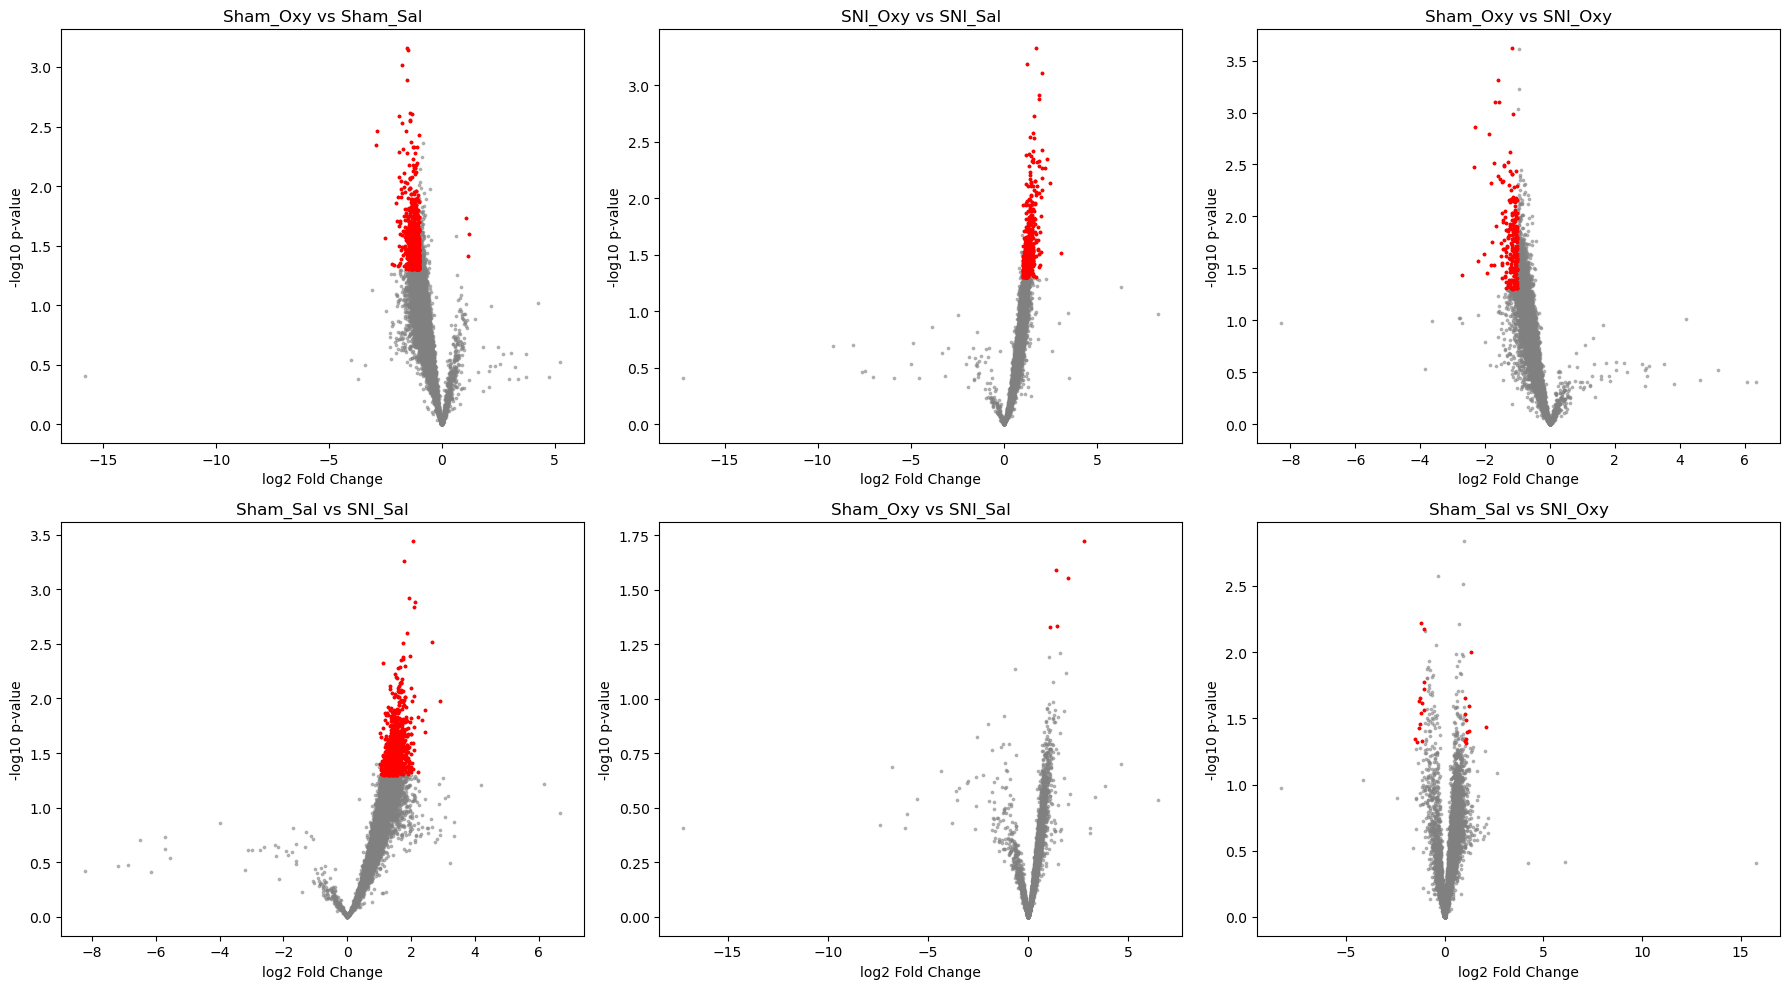

In [27]:
from scipy.stats import ttest_ind
import numpy as np
import matplotlib.pyplot as plt

expression_numeric = expression_data[expr_cols].astype(float)

groups = {
    "Sham_Oxy": ["Sham_oxy_1", "Sham_oxy_2", "Sham_oxy_3", "Sham_oxy_4"],
    "Sham_Sal": ["Sham_Sal_1", "Sham_Sal_2", "Sham_Sal_3", "Sham_Sal_4"],
    "SNI_Oxy": ["SNI_oxy_1", "SNI_oxy_2", "SNI_oxy_3", "SNI_oxy_4"],
    "SNI_Sal": ["SNI_Sal_1", "SNI_Sal_2", "SNI_Sal_3", "SNI_Sal_4"],
}

results = []

def compare_groups(group1, group2):

    samples1 = groups[group1]
    samples2 = groups[group2]

    for i, row in expression_numeric.iterrows():
        
        gene_id = expression_data.loc[i, "gene_id"]
        gene_name = expression_data.loc[i, "gene_name"]

        vals1 = row[samples1].values
        vals2 = row[samples2].values
        
        # t-Test
        stat, pval = ttest_ind(vals1, vals2, equal_var=False)
        
        # log2 FC
        mean1 = np.mean(vals1 + 1)
        mean2 = np.mean(vals2 + 1)
        log2fc = np.log2(mean1 / mean2)
        
        results.append({"gene_id": gene_id, "gene_name": gene_name, "group1": group1, "group2": group2, "log2FC": log2fc, "pval": pval})


pairs = [("Sham_Oxy", "Sham_Sal"), ("SNI_Oxy", "SNI_Sal"), ("Sham_Oxy", "SNI_Oxy"), ("Sham_Sal", "SNI_Sal"), ("Sham_Oxy", "SNI_Sal"), ("Sham_Sal", "SNI_Oxy")]

for g1, g2 in pairs:
    compare_groups(g1, g2)

de_results = pd.DataFrame(results)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (g1, g2) in enumerate(pairs):
    subset = de_results[(de_results.group1==g1) & (de_results.group2==g2)]
    
    axes[i].scatter(subset["log2FC"], -np.log10(subset["pval"]), c='gray', alpha=0.5, s=3)
    
    sig = subset[(abs(subset["log2FC"])>1) & (subset["pval"]<0.05)]
    axes[i].scatter(sig["log2FC"], -np.log10(sig["pval"]), c='red', s=3)
    
    axes[i].set_xlabel("log2 Fold Change")
    axes[i].set_ylabel("-log10 p-value")
    axes[i].set_title(f"{g1} vs {g2}")

plt.tight_layout()
plt.show()


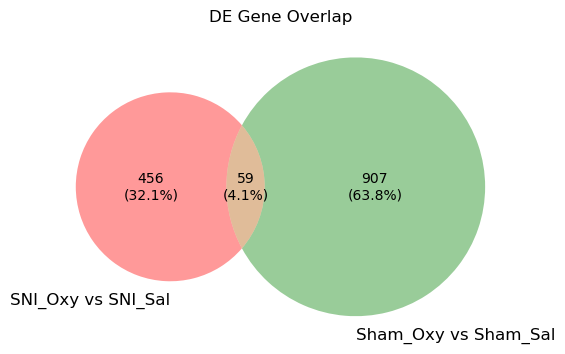

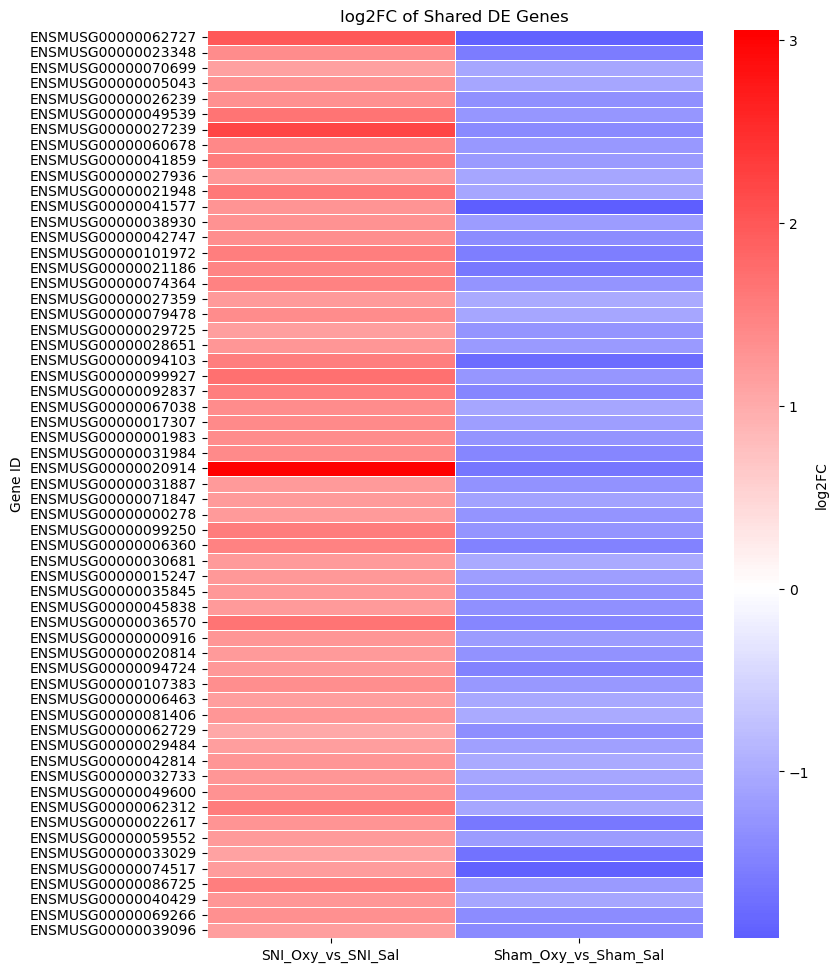

In [35]:
from matplotlib_venn import venn2
import seaborn as sns

threshold_log2fc = 1
threshold_pval = 0.05

# Get DE-Genes for comparision
def get_de_genes(group1, group2):
    subset = de_results[
        (de_results.group1==group1) &
        (de_results.group2==group2) &
        (abs(de_results.log2FC) > threshold_log2fc) &
        (de_results.pval < threshold_pval)
    ]
    return set(subset["gene_id"]), subset.set_index("gene_id")["log2FC"]

de_sni, log2fc_sni = get_de_genes("SNI_Oxy", "SNI_Sal")
de_sham, log2fc_sham = get_de_genes("Sham_Oxy", "Sham_Sal")

# Plot
plt.figure(figsize=(6,6))
v = venn2([de_sni, de_sham], set_labels=("SNI_Oxy vs SNI_Sal", "Sham_Oxy vs Sham_Sal"))

# Percentage stuff for labels in venn diagramm
for idx in ["10", "01", "11"]:  # 10=SNI only, 01=Sham only, 11=both
    if v.get_label_by_id(idx) is not None:
        n = int(v.get_label_by_id(idx).get_text())
        total = len(de_sni.union(de_sham))
        v.get_label_by_id(idx).set_text(f"{n}\n({n/total*100:.1f}%)")

plt.title("DE Gene Overlap")
plt.show()

# Common genes for heatmap
common_genes = list(de_sni.intersection(de_sham))
heatmap_data = pd.DataFrame({"SNI_Oxy_vs_SNI_Sal": log2fc_sni.loc[common_genes], "Sham_Oxy_vs_Sham_Sal": log2fc_sham.loc[common_genes]})

# Plot
plt.figure(figsize=(8, max(2, len(common_genes)*0.2)))
sns.heatmap(heatmap_data, cmap="bwr", center=0, cbar_kws={"label":"log2FC"}, linewidths=0.5)
plt.title("log2FC of Shared DE Genes")
plt.ylabel("Gene ID")
plt.show()

